# Movie Recommendion System CPCS AI-Receptive Software Development

1. Importing the dependencies
1. Loading the data
1. Exploratory data analysis 
1. Data pre-processing
1. Collaborative filtering using k-Nearest Neighbors
1. Handling the cold-start problem with content-based filtering 


### Step 1: Import Dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

I downloaded a 1 million point input version of the MovieLens dataset.

We're working with data in `ml-1m.zip` and will need to add the following files to our repository:

- ratings.csv
- movies.csv
- Users.csv


In [6]:
path = "data/ml-1m/"
users = pd.read_csv(path+"users.csv", sep=";")
ratings = pd.read_csv(path+"ratings.csv", sep=";")
movies = pd.read_csv(path + "movies.csv", sep=";", encoding="latin", on_bad_lines='skip')


### Step 3: Exploratory Data Analysis

In [7]:
for df in [users, ratings, movies]:
    print(df.head())
    print("______________________________")

    1::F::1::10::48067
0  2::M::56::16::70072
1  3::M::25::15::55117
2   4::M::45::7::02460
3  5::M::25::20::55455
4   6::F::50::9::55117
______________________________
   1::1193::5::978300760
0   1::661::3::978302109
1   1::914::3::978301968
2  1::3408::4::978300275
3  1::2355::5::978824291
4  1::1197::3::978302268
______________________________
  1::Toy Story (1995)::Animation|Children's|Comedy
0  2::Jumanji (1995)::Adventure|Children's|Fantasy
1       3::Grumpier Old Men (1995)::Comedy|Romance
2        4::Waiting to Exhale (1995)::Comedy|Drama
3    5::Father of the Bride Part II (1995)::Comedy
4            6::Heat (1995)::Action|Crime|Thriller
______________________________


In [8]:
print("Ratings columns:", ratings.columns)
print("Users columns:", users.columns)


Ratings columns: Index(['1::1193::5::978300760'], dtype='object')
Users columns: Index(['1::F::1::10::48067'], dtype='object')


In [9]:
# Read the users file with the correct delimiter
users = pd.read_csv(path + "users.csv", sep="::", engine="python", header=None)
users.columns = ['userId', 'gender', 'age', 'occupation', 'zip']

# Read the ratings file with the correct delimiter
ratings = pd.read_csv(path + "ratings.csv", sep="::", engine="python", header=None)
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']

# Read the movies file with the correct delimiter
movies = pd.read_csv(path + "movies.csv", sep="::", engine="python", header=None, encoding='ISO-8859-1')
movies.columns = ['movieId', 'title', 'genres']

# Print the first few rows to verify
print("Users DataFrame:")
print(users.head())

print("Ratings DataFrame:")
print(ratings.head())

print("Movies DataFrame:")
print(movies.head())

Users DataFrame:
   userId gender  age  occupation    zip
0       1      F    1          10  48067
1       2      M   56          16  70072
2       3      M   25          15  55117
3       4      M   45           7  02460
4       5      M   25          20  55455
Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Movies DataFrame:
   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


In [10]:
ratings.columns = ratings.columns.str.strip()  # Remove leading/trailing spaces from column names

In [11]:
print("Columns in ratings DataFrame:", ratings.columns)

Columns in ratings DataFrame: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [12]:
# Number of ratings (rows in ratings DataFrame)
n_ratings = len(ratings)

# Number of unique movies (unique movieId in movies DataFrame)
n_movies = len(movies)

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 1000209
Number of unique movieId's: 3883
Average number of ratings per movie: 257.59


### What is the distribution of movie ratings?

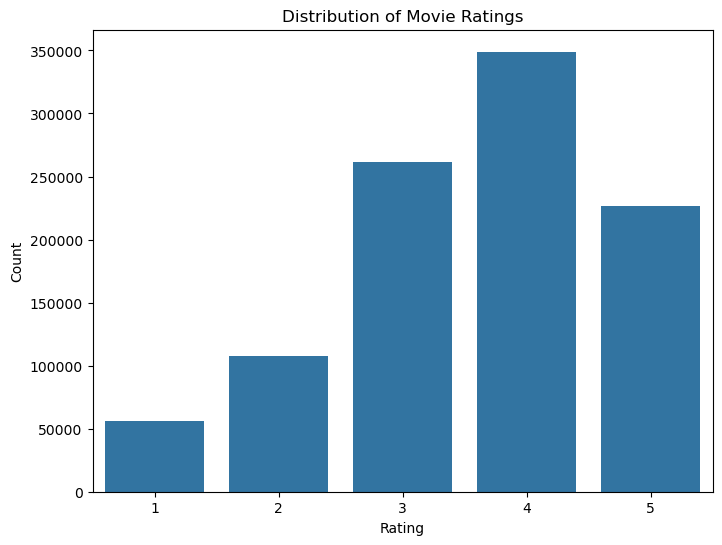

Rating distribution:
rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram to visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Calculate the count of each unique rating
rating_counts = ratings['rating'].value_counts().sort_index()

# Print the distribution of ratings
print("Rating distribution:")
print(rating_counts)

In [14]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.58.


In [15]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}.")

Mean rating per user: 3.7.


### Which movies are most frequently rated?

In [16]:
# Merge ratings with movies on 'movieId'
movie_ratings = ratings.merge(movies, on='movieId')

# Get the top 10 most frequently rated movie titles
top_10_movies = movie_ratings['title'].value_counts().head(10)
print(top_10_movies)

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: count, dtype: int64


Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

### What are the lowest and highest rated movies? 

Which movie has the lowest and highest average rating?

In [17]:
# Merge ratings with movies on 'movieId'
movie_ratings = ratings.merge(movies, on='movieId')

In [18]:
#Find the movie with the lowest and highest number of ratings
ratings_count = movie_ratings['title'].value_counts()
lowest_rated_movie_count = ratings_count.idxmin()  
highest_rated_movie_count = ratings_count.idxmax()

print (lowest_rated_movie_count)
print (highest_rated_movie_count)

Detroit 9000 (1973)
American Beauty (1999)


In [19]:
#  Find the movie with the lowest and highest average rating
average_ratings = movie_ratings.groupby('title')['rating'].mean()
lowest_rated_movie_avg = average_ratings.idxmin() 
highest_rated_movie_avg = average_ratings.idxmax() 

print (lowest_rated_movie_avg)
print (highest_rated_movie_avg)

Blood Spattered Bride, The (La Novia Ensangrentada) (1972)
Baby, The (1973)


#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. 

- $C$ represents "the typical data set size". In this case, $C$ will be the average number of ratings for a given movie.
- $m$ represents the average rating across all movies 

In [20]:
# 1. Calculate the global average rating across all movies
global_avg_rating = movie_ratings['rating'].mean()

# 2. Calculate the average number of ratings per movie
avg_ratings_per_movie = movie_ratings.groupby('title')['rating'].count().mean()

# 3. Calculate the average rating for each movie
movie_avg_ratings = movie_ratings.groupby('title')['rating'].mean()

# 4. Calculate the number of ratings for each movie
movie_ratings_count = movie_ratings.groupby('title')['rating'].count()

# 5. Compute the Bayesian Average for each movie
C = global_avg_rating
m = avg_ratings_per_movie
movie_stats = movie_ratings_count.to_frame(name='num_ratings')
movie_stats['avg_rating'] = movie_avg_ratings
movie_stats['bayesian_avg'] = (movie_stats['num_ratings'] * movie_stats['avg_rating'] + m * C) / (movie_stats['num_ratings'] + m)

# Sort movies by Bayesian Average
movie_stats = movie_stats.sort_values(by='bayesian_avg', ascending=False)

# Display top 5 movies with the highest Bayesian Average
print(movie_stats.head())

                                  num_ratings  avg_rating  bayesian_avg
title                                                                  
Shawshank Redemption, The (1994)         2227    4.554558      4.449387
Godfather, The (1972)                    2223    4.524966      4.422830
Schindler's List (1993)                  2304    4.510417      4.413020
Usual Suspects, The (1995)               1783    4.517106      4.394112
Raiders of the Lost Ark (1981)           2514    4.477725      4.390845


In [21]:
# C: Average number of ratings for a given movie
C = movie_stats['num_ratings'].mean()

# m: Average rating for a given movie
m = movie_stats['avg_rating'].mean()

# Print out the averages
print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

# Define the function to calculate Bayesian Average
def bayesian_avg(v, R, C, m):
    """
    v: number of ratings for a movie
    R: average rating for the movie
    C: global average rating across all movies
    m: average number of ratings per movie
    """
    bayesian_avg_rating = (v * R + m * C) / (v + m)
    return round(bayesian_avg_rating, 2)

# Example usage: calculate the Bayesian Average for a movie
example_movie = movie_stats.iloc[0]  # Just an example, you can choose any movie
v = example_movie['num_ratings']
R = example_movie['avg_rating']
print(f"Bayesian Average for movie '{example_movie.name}': {bayesian_avg(v, R, C, m)}")

Average number of ratings for a given movie: 269.89
Average rating for a given movie: 3.24
Bayesian Average for movie 'Shawshank Redemption, The (1994)': 4.94


In [22]:
# Group the ratings data by movieId to calculate stats
movie_stats = ratings.groupby('movieId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Calculate the Bayesian average for each movie (as you have done before)
movie_stats['bayesian_avg'] = movie_stats.apply(
    lambda row: bayesian_avg(row['num_ratings'], row['avg_rating'], C, m), axis=1)

In [23]:
# Merge movie_stats with movie titles
movie_stats = movie_stats.merge(movies[['movieId', 'title']], on='movieId')

# Sort by 'avg_rating' in descending order (if you want the highest rated movies on top)
movie_stats = movie_stats.sort_values(by='avg_rating', ascending=False)

# Display the top rows to verify the result
print(movie_stats.head())


      movieId  num_ratings  avg_rating  bayesian_avg  \
926       989            1         5.0        207.40   
3635     3881            1         5.0        207.40   
1652     1830            1         5.0        207.40   
3152     3382            1         5.0        207.40   
744       787            3         5.0        142.52   

                                          title  
926   Schlafes Bruder (Brother of Sleep) (1995)  
3635                   Bittersweet Motel (2000)  
1652                    Follow the Bitch (1998)  
3152                     Song of Freedom (1936)  
744          Gate of Heavenly Peace, The (1995)  


In [24]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,num_ratings,avg_rating,bayesian_avg,title
2496,2701,902,2.158537,3.12,Wild Wild West (1999)
2494,2699,1367,3.002926,3.63,Arachnophobia (1990)
3126,3354,793,2.595208,3.68,Mission to Mars (2000)
1435,1562,606,2.257426,3.68,Batman & Robin (1997)
1292,1391,1074,2.900372,3.70,Mars Attacks! (1996)


### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [25]:
import pandas as pd
import re

# Load movies dataset (assuming you already have the `movies` DataFrame)
# movies = pd.read_csv("movies.csv", ...)

# Step 1: Clean the 'genres' column
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Step 2: Extract the year from the 'title' column
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Remove the year from the 'title' column
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '').str.strip()

# Display the first few rows to check the results
print(movies.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                             genres  year  
0   [Animation, Children's, Comedy]  1995  
1  [Adventure, Children's, Fantasy]  1995  
2                 [Comedy, Romance]  1995  
3                   [Comedy, Drama]  1995  
4                          [Comedy]  1995  


**How many movie genres are there?**

In [26]:
#Flatten the list of genres for each movie and find the unique genres
all_genres = [genre for sublist in movies['genres'] for genre in sublist]

# Get the unique genres
unique_genres = set(all_genres)

# Print the number of unique genres
print(f"Total unique movie genres: {len(unique_genres)}")


Total unique movie genres: 18


In [27]:
from collections import Counter

# Flatten the list of genres for each movie
all_genres = [genre for sublist in movies['genres'] for genre in sublist]

# Count the frequency of each genre
genre_frequency = Counter(all_genres)

# Get the 5 most common genres
print("The 5 most common genres: \n", genre_frequency.most_common(5))


The 5 most common genres: 
 [('Drama', 1603), ('Comedy', 1200), ('Action', 503), ('Thriller', 492), ('Romance', 471)]


In [28]:
import pandas as pd
from collections import Counter

# Flatten the list of genres for each movie
all_genres = [genre for sublist in movies['genres'] for genre in sublist]

# Count the frequency of each genre
genre_frequency = Counter(all_genres)

# Create a DataFrame from the Counter
genre_frequency_df = pd.DataFrame(genre_frequency.items(), columns=['Genre', 'Frequency'])

# Sort by frequency in descending order
genre_frequency_df = genre_frequency_df.sort_values(by='Frequency', ascending=False)

# Print the DataFrame
print(genre_frequency_df)


          Genre  Frequency
6         Drama       1603
2        Comedy       1200
7        Action        503
9      Thriller        492
5       Romance        471
10       Horror        343
3     Adventure        283
11       Sci-Fi        276
1    Children's        251
8         Crime        211
13          War        143
12  Documentary        127
14      Musical        114
15      Mystery        106
0     Animation        105
4       Fantasy         68
17      Western         68
16    Film-Noir         44


### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.


The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [29]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Load ratings data with correct column names
path = "data/ml-1m/"
ratings = pd.read_csv(path+"ratings.csv", sep="::", engine="python", header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

# Strip any leading/trailing spaces in column names
ratings.columns = ratings.columns.str.strip()

# Check the first few rows to understand the structure of the data
print(ratings.head())

def create_X(df):
    """
    Generates a sparse user-item matrix from the ratings dataframe.
    
    Args:
        df: pandas dataframe containing columns: userId, movieId, rating
    
    Returns:
        X: sparse user-item matrix
        user_mapper: dict mapping userId to user index
        movie_mapper: dict mapping movieId to movie index
        user_inv_mapper: dict mapping user index to userId
        movie_inv_mapper: dict mapping movie index to movieId
    """
    # Get the number of unique users and movies
    M = df['userId'].nunique()  # Number of unique users
    N = df['movieId'].nunique()  # Number of unique movies

    # Create mappings from user/movie IDs to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    # Convert userId and movieId to indices
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # Create the sparse matrix X
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

# Create the user-item matrix
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

# Check the shape of the sparse matrix
print("Sparse Matrix Shape:", X.shape)

# Check the first few entries of the user_mapper and movie_mapper
print("First 5 user IDs and their indices:", list(user_mapper.items())[:5])
print("First 5 movie IDs and their indices:", list(movie_mapper.items())[:5])



   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Sparse Matrix Shape: (6040, 3706)
First 5 user IDs and their indices: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4)]
First 5 movie IDs and their indices: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4)]


In [30]:
# Print the column names to check if 'userId', 'movieId', and 'rating' exist
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [31]:
# Strip any leading or trailing spaces from the column names
ratings.columns = ratings.columns.str.strip()

# Print the cleaned column names to verify
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [32]:
# Strip any leading or trailing spaces from the column names
ratings.columns = ratings.columns.str.strip()

# Print the cleaned column names to verify
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements.

In [33]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Step 1: Load the ratings data
path = "data/ml-1m/"  # Make sure to change this path if needed
ratings = pd.read_csv(path + "ratings.csv", sep="::", header=None, names=["userId", "movieId", "rating", "timestamp"], engine="python")

# Step 2: Create the user-item sparse matrix
def create_X(df):
    """
    Creates a sparse matrix from ratings dataframe.
    """
    M = df['userId'].nunique()  # Number of unique users
    N = df['movieId'].nunique()  # Number of unique movies

    # Create mappings from user/movie IDs to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    # Create inverse mappings (index to ID)
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    # Get user and movie indices for the sparse matrix
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    
    # Create the sparse matrix (CSR format)
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))
    
    return X

# Create the sparse matrix X
X = create_X(ratings)

# Step 3: Calculate the sparsity of the user-item matrix
nnz = X.nnz  # Number of non-zero elements (ratings)
total_elements = X.shape[0] * X.shape[1]  # Total number of elements in the matrix

# Sparsity calculation
sparsity = nnz / total_elements  # Sparsity = non-zero elements / total elements

# Display results
print(f"Total elements: {total_elements}")
print(f"Non-zero elements (ratings): {nnz}")
print(f"Sparsity of the matrix: {sparsity:.4f}")

Total elements: 22384240
Non-zero elements (ratings): 1000209
Sparsity of the matrix: 0.0447


In [34]:
# Step 1: Calculate the number of ratings per user
n_ratings_per_user = ratings.groupby('userId').size()

# Step 2: Get the length of the result (i.e., number of users with ratings)
num_users_with_ratings = len(n_ratings_per_user)

# Display the results
print(f"Number of ratings per user: {n_ratings_per_user.head()}")  # Display first few
print(f"Number of users with ratings: {num_users_with_ratings}")

Number of ratings per user: userId
1     53
2    129
3     51
4     21
5    198
dtype: int64
Number of users with ratings: 6040


In [35]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2314 movies.
Least active user rated 20 movies.


In [36]:
# Step 1: Calculate the number of ratings per movie
n_ratings_per_movie = ratings.groupby('movieId').size()

# Step 2: Get the length of the result (i.e., number of movies with ratings)
num_movies_with_ratings = len(n_ratings_per_movie)

# Display the results
print(f"Number of ratings per movie: {n_ratings_per_movie.head()}")  # Display first few
print(f"Number of movies with ratings: {num_movies_with_ratings}")

Number of ratings per movie: movieId
1    2077
2     701
3     478
4     170
5     296
dtype: int64
Number of movies with ratings: 3706


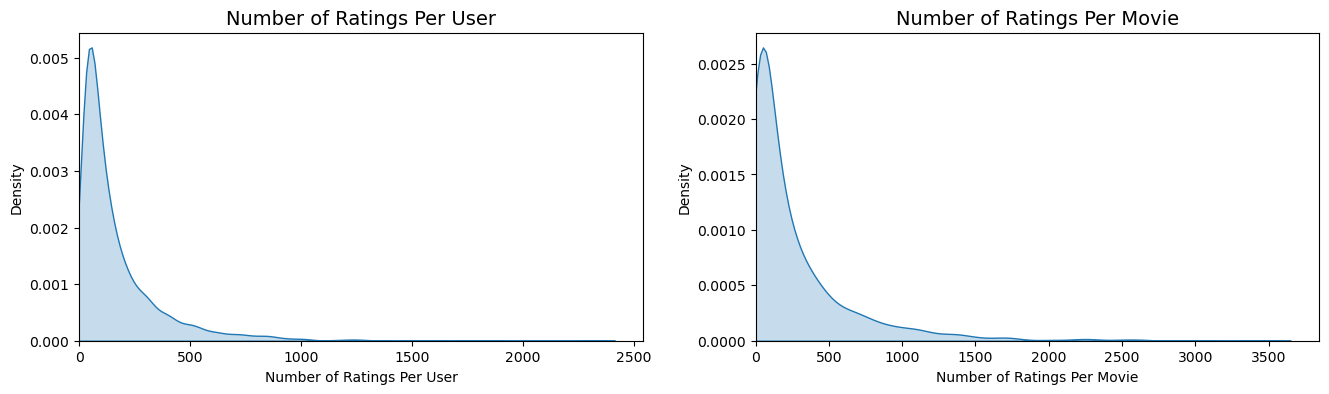

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming n_ratings_per_user and n_ratings_per_movie are already calculated

# Create the figure
plt.figure(figsize=(16,4))

# Plot the KDE for number of ratings per user
plt.subplot(1, 2, 1)
sns.kdeplot(n_ratings_per_user, fill=True)  # Update here: shade=True → fill=True
plt.xlim(0)  # Set x-axis limit starting from 0
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("Number of Ratings Per User")
plt.ylabel("Density")

# Plot the KDE for number of ratings per movie
plt.subplot(1, 2, 2)
sns.kdeplot(n_ratings_per_movie, fill=True)  # Update here: shade=True → fill=True
plt.xlim(0)  # Set x-axis limit starting from 0
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("Number of Ratings Per Movie")
plt.ylabel("Density")

# Show the plot
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [38]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Create movie_mapper and movie_inv_mapper
movie_mapper = {movie_id: index for index, movie_id in enumerate(ratings['movieId'].unique())}
movie_inv_mapper = {index: movie_id for movie_id, index in movie_mapper.items()}

# Create the user-item matrix X
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
X = csr_matrix(user_movie_matrix.values)

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T  # Transpose the matrix (movies are now rows)
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]  # Get the index of the movie in the matrix
    movie_vec = X[movie_ind]
    
    if isinstance(movie_vec, np.ndarray):
        movie_vec = movie_vec.reshape(1,-1)  # Reshape to a 2D array for kNN
    
    # Use k+1 since kNN includes the movieId of interest itself
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)  # Fit the kNN model on the movie vectors
    neighbours = kNN.kneighbors(movie_vec, return_distance=False)
    
    # Collect the movie IDs of the k nearest neighbours
    for i in range(0, k):
        n = neighbours.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    
    neighbour_ids.pop(0)  # Remove the movie ID itself from the list
    return neighbour_ids


In [39]:
# Assuming the function 'find_similar_movies' is already defined and the necessary data is available

# Example: Get 10 similar movies to movie ID 1
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)

# Display the similar movie IDs
print(similar_movies)


[842, 1268, 1186, 2004, 2993, 2021, 178, 372, 132]


In [40]:
# Assuming the movie_titles dictionary and the movie_id are already defined

movie_titles = dict(zip(movies['movieId'], movies['title']))  # Create movie title dictionary

movie_id = 1  # Example movie ID to find similar movies

# Get similar movies using the find_similar_movies function
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)

# Get the title of the movie you watched
movie_title = movie_titles[movie_id]

# Display the results
print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(f"- {movie_titles[i]}")


Because you watched Toy Story (1995):
- Tales from the Crypt Presents: Bordello of Blood (1996)
- Pump Up the Volume (1990)
- Sex, Lies, and Videotape (1989)
- Gremlins 2: The New Batch (1990)
- Thunderball (1965)
- Dune (1984)
- Love & Human Remains (1993)
- Reality Bites (1994)
- Jade (1995)


In [41]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Crow, The (1994)
Better Than Chocolate (1999)
Moonraker (1979)
Mr. Jones (1993)
Speechless (1994)
Trading Places (1983)
Rambo III (1988)
Breakfast of Champions (1999)
Meteor (1979)


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system.

In [42]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 3883 unique movies in our movies dataset.


In [43]:
#  Extract unique genres
genres = set()
for genre_list in movies['genres']:
    genres.update(genre_list)  # Add genres directly since it's already a list

#  Create binary columns for each genre
for g in genres:
    movies[g] = movies['genres'].apply(lambda x: 1 if g in x else 0)

# Drop unnecessary columns and keep only the binary genre columns
movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

# Now `movie_genres` will contain a DataFrame with binary columns for each genre.


In [44]:
movie_genres.head()

,year,Musical,War,Film-Noir,Action,Thriller,Horror,Sci-Fi,Crime,Western,Mystery,Documentary,Adventure,Animation,Children's,Drama,Fantasy,Comedy,Romance
0,1995,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,1995,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (3883, 3883)


### Creating a movie finder function
Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In [46]:
from fuzzywuzzy import process

def movie_finder(title):
    # List of all movie titles
    all_titles = movies['title'].tolist()
    
    # Use fuzzywuzzy's process.extractOne to find the closest match
    closest_match = process.extractOne(title, all_titles)
    
    # Return the closest matching title
    return closest_match[0]


Let's test this out with our Jumanji example. 

In [47]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [48]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [49]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


In [50]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


353                    Four Weddings and a Funeral (1994)
2774    Black Cat, White Cat (Crna macka, beli macor) ...
3638                                Nine 1/2 Weeks (1986)
498                           Next Karate Kid, The (1994)
378                                           Wolf (1994)
3039                              Fisher King, The (1991)
2404                                      Soul Man (1986)
2507                                    Love, etc. (1996)
2526                     Photographer (Fotoamator) (1998)
Name: title, dtype: object

In [51]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [52]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1050        Aladdin and the King of Thieves (1996)
2285                     Rugrats Movie, The (1998)
2286                          Bug's Life, A (1998)
3045                            Toy Story 2 (1999)
2073    American Tail: Fievel Goes West, An (1991)
Name: title, dtype: object


In [53]:
#1. Prepare Data for Neural Collaborative Filtering (NCF):
#You already have the sparse matrix X that holds the user-item interactions. You will need to format this data into training and testing sets.

In [54]:
!pip install tensorflow

In [55]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Create training and testing data (80% train, 20% test)
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Prepare training data (userId, movieId, rating)
train_users = train['userId'].values
train_movies = train['movieId'].values
train_ratings = train['rating'].values

# Prepare test data (userId, movieId, rating)
test_users = test['userId'].values
test_movies = test['movieId'].values
test_ratings = test['rating'].values



In [56]:
#2. Create a Model Architecture (NCF):
#You can use Neural Collaborative Filtering (NCF) for the recommendation system, where embeddings are used for both users and movies, followed by a feed-forward neural network to predict ratings.

In [57]:
from tensorflow.keras.layers import Embedding, Dense, Flatten, Concatenate, Input
from tensorflow.keras.models import Model

# Define parameters
num_users = len(user_mapper)
num_movies = len(movie_mapper)
embedding_size = 50  # You can adjust this hyperparameter

# Build the NCF model
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size)(movie_input)

# Flatten the embeddings
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = Concatenate()([user_vec, movie_vec])

# Feed-forward neural network
fc1 = Dense(128, activation='relu')(concat)
fc2 = Dense(64, activation='relu')(fc1)
output = Dense(1)(fc2)

# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 50)             │         302,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 50)             │         185,300 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 50)                │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 50)                │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 100)               │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          12,928 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 508,549 (1.94 MB)

 Trainable params: 508,549 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
#Train the Model:

In [59]:
from sklearn.preprocessing import LabelEncoder

# Combine training and test movie IDs to create a unified encoder
movie_encoder = LabelEncoder()
all_movie_ids = pd.concat([train['movieId'], test['movieId']])

# Fit the encoder on the combined movie IDs
movie_encoder.fit(all_movie_ids)

# Transform movie IDs in both training and test sets
train['movieId'] = movie_encoder.transform(train['movieId'])
test['movieId'] = movie_encoder.transform(test['movieId'])

# Apply similar transformation for userIds if needed
user_encoder = LabelEncoder()
user_encoder.fit(train['userId'])  # Fit only on training set

train['userId'] = user_encoder.transform(train['userId'])
test['userId'] = user_encoder.transform(test['userId'])

# Now, update the variables for training
train_users = train['userId'].values
train_movies = train['movieId'].values
train_ratings = train['rating'].values

test_users = test['userId'].values
test_movies = test['movieId'].values
test_ratings = test['rating'].values

# Get the number of unique users and movies
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)


In [60]:
# Define the model again with updated indices
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size)(movie_input)

# Flatten the embeddings
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = Concatenate()([user_vec, movie_vec])

# Feed-forward neural network
fc1 = Dense(128, activation='relu')(concat)
fc2 = Dense(64, activation='relu')(fc1)
output = Dense(1)(fc2)

# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([train_users, train_movies], train_ratings, epochs=20, batch_size=512, validation_split=0.1)


Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.2101 - val_loss: 0.8280
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8075 - val_loss: 0.8007
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7750 - val_loss: 0.7827
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7388 - val_loss: 0.7712
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7078 - val_loss: 0.7705
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6649 - val_loss: 0.7742
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6292 - val_loss: 0.7818
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5911 - val_loss: 0.8006
Epoch 9/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5564 - val_loss: 0.8075
Epoch 10/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5226 - val_loss: 0.8206
Epoch 11/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4937 - val_loss: 0.8329
Epoch 12/20
1407/1407 ━━━━━━━━

In [61]:
#Step 2: Evaluate the Model's Performance
#You can evaluate the performance of the collaborative filtering model using precision and recall. First, you'll need to calculate the predicted ratings for the test set and then compare them to the actual ratings to compute these metrics.

In [62]:
# Predict ratings on the test set
test_predictions = model.predict([test_users, test_movies])

# Round the predictions to get predicted ratings (for simplicity)
predicted_ratings = test_predictions.round()


6252/6252 ━━━━━━━━━━━━━━━━━━━━ 3s 515us/step


In [63]:
#2. Precision and Recall Calculation:
#Precision and recall are typically used in classification tasks, but we can define a threshold for "relevant" ratings (e.g., ratings greater than 3 as positive).

In [64]:
from sklearn.metrics import precision_score, recall_score

# Define a threshold for relevant ratings
threshold = 3

# Convert actual and predicted ratings to binary values (1 for relevant, 0 for irrelevant)
y_true = (test_ratings >= threshold).astype(int)
y_pred = (predicted_ratings >= threshold).astype(int)

# Calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Precision: 0.8856
Recall: 0.9417


In [65]:
#Step 3: Content-Based Filtering Model
#While collaborative filtering works by analyzing user-item interactions, content-based filtering works by utilizing information about the movies themselves (such as genres, descriptions, etc.).

In [66]:
#Create Features for Content-Based Filtering:
#You can use movie genres as features for content-based filtering. You need to encode these features and train a model based on these.

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarize the genres column
mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(movies['genres'])

# Create a DataFrame with the genres
genres_df = pd.DataFrame(genres_matrix, columns=mlb.classes_)

# Print the first few rows to verify
print(genres_df.head())


   Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
0       0          0          1           1       1      0            0   
1       0          1          0           1       0      0            0   
2       0          0          0           0       1      0            0   
3       0          0          0           0       1      0            0   
4       0          0          0           0       1      0            0   

   Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
0      0        0          0       0        0        0        0       0   
1      0        1          0       0        0        0        0       0   
2      0        0          0       0        0        0        1       0   
3      1        0          0       0        0        0        0       0   
4      0        0          0       0        0        0        0       0   

   Thriller  War  Western  
0         0    0        0  
1         0    0        0  
2         0   

In [68]:
#Build a Content-Based Model (Using Cosine Similarity):
#You can use Cosine Similarity to find similar movies based on their genres.

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix between all movies based on genres
cosine_sim = cosine_similarity(genres_df)

# Function to get movie recommendations
def get_movie_recommendations(movie_id, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the movieId
    idx = movie_mapper[movie_id]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

# Get recommendations for a movie (e.g., movieId 1)
recommendations = get_movie_recommendations(1)
print(recommendations)


153         Beyond Rangoon (1995)
332      Walking Dead, The (1995)
523       Schindler's List (1993)
641     Courage Under Fire (1996)
967       Nothing Personal (1995)
979        Michael Collins (1996)
1074               Platoon (1986)
1162        Paths of Glory (1957)
1190        Apocalypse Now (1979)
1199                   Ran (1985)
Name: title, dtype: object


In [70]:
#Step 4: Hyperparameter Tuning
#For both models, you can experiment with different hyperparameters (e.g., embedding size, learning rate, batch size) to optimize the model's performance. You can use GridSearchCV or RandomizedSearchCV to tune the hyperparameters in a systematic way.

In [71]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [75]:
user_mapping = {user_id: idx for idx, user_id in enumerate(train['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(train['movieId'].unique())}


In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras import layers, models
import tensorflow as tf

# Assuming `train` is your DataFrame with 'userId', 'movieId', and 'rating' columns

# Convert userId and movieId to zero-based indices
user_to_index = {user_id: index for index, user_id in enumerate(train['userId'].unique())}
movie_to_index = {movie_id: index for index, movie_id in enumerate(train['movieId'].unique())}

train['userId'] = train['userId'].map(user_to_index)
train['movieId'] = train['movieId'].map(movie_to_index)

# Get the number of unique users and movies in the dataset after re-indexing
num_users = len(user_to_index)
num_movies = len(movie_to_index)

def build_model(hp, num_users, num_movies):
    # Hyperparameters to tune
    embedding_size = hp.Int('embedding_size', min_value=8, max_value=128, step=8)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    batch_size = hp.Int('batch_size', min_value=32, max_value=512, step=32)
    
    # Model definition
    user_input = layers.Input(shape=(1,))
    movie_input = layers.Input(shape=(1,))
    
    user_embedding = layers.Embedding(num_users, embedding_size)(user_input)
    movie_embedding = layers.Embedding(num_movies, embedding_size)(movie_input)

    # Dot product of user and movie embeddings
    dot_product = layers.Dot(axes=1)([user_embedding, movie_embedding])
    
    # Flatten the result to make it compatible with the output layer
    dot_product = layers.Flatten()(dot_product)
    
    # Output layer: Single node for rating prediction
    output = layers.Dense(1)(dot_product)
    
    model = models.Model(inputs=[user_input, movie_input], outputs=output)
    
    # Compile the model with a dynamically tuned learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

# Split the data into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

# Extract userId, movieId, and rating columns for both training and validation sets
train_users = train_data['userId'].values
train_movies = train_data['movieId'].values
train_ratings = train_data['rating'].values

val_users = val_data['userId'].values
val_movies = val_data['movieId'].values
val_ratings = val_data['rating'].values

# Set up the Keras Tuner with RandomSearch or Hyperband
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, num_users, num_movies),  # Pass num_users and num_movies to the model builder
    objective='val_loss',  # You can use 'loss' or 'accuracy' based on your preference
    max_trials=5,  # Limit number of trials to avoid long execution times
    executions_per_trial=1,  # How many times to run each model
    directory='my_dir',  # Directory where the results will be saved
    project_name='movie_rec_tuning'
)

# Perform the hyperparameter search
tuner.search([train_users, train_movies], train_ratings, epochs=20, batch_size=64, validation_data=([val_users, val_movies], val_ratings))

# Get the best hyperparameters from the best trial
best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
print("Best Hyperparameters: ", best_hyperparameters)

# Rebuild the model using the best hyperparameters
best_model = build_model(tuner.oracle.get_best_trials(1)[0].hyperparameters, num_users, num_movies)

# Retrain the best model with your training data
best_model.fit([train_users, train_movies], train_ratings, epochs=20, batch_size=64, validation_data=([val_users, val_movies], val_ratings))


Reloading Tuner from my_dir\movie_rec_tuning\tuner0.json
Best Hyperparameters:  {'embedding_size': 16, 'learning_rate': 0.0023522136902796916, 'batch_size': 320}
Epoch 1/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 3.1351 - val_loss: 0.9142
Epoch 2/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.8635 - val_loss: 0.8254
Epoch 3/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.7740 - val_loss: 0.7859
Epoch 4/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.7142 - val_loss: 0.7789
Epoch 5/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.6649 - val_loss: 0.7786
Epoch 6/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.6332 - val_loss: 0.7814
Epoch 7/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.6083 - val_loss: 0.7953
Epoch 8/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.5884 - val_loss: 0.8052
Epoch 9/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.5734 - val_loss: 0.8089
Epoch 10/20
10003/1

In [84]:
assert test_users.min() >= 0 and test_movies.min() >= 0, "Invalid user or movie indices detected!"


AssertionError: Invalid user or movie indices detected!

In [85]:
print(f"Number of unique users in training set: {len(user_mapping)}")
print(f"Number of unique movies in training set: {len(movie_mapping)}")


Number of unique users in training set: 6040
Number of unique movies in training set: 3683


In [86]:
print(user_mapping.keys())[:10]
print(movie_mapping.keys())[:10]


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

TypeError: 'NoneType' object is not subscriptable

In [87]:
# Remap movie indices to a valid range
test_movies = np.clip(test_movies, 0, num_movies - 1)

# Filter out test data with invalid movie indices
valid_test_data = [(user, movie, rating) for user, movie, rating in zip(test_users, test_movies, test_ratings)
                    if movie < num_movies]

# Unzip the valid test data
test_users, test_movies, test_ratings = zip(*valid_test_data)
test_users, test_movies, test_ratings = np.array(test_users), np.array(test_movies), np.array(test_ratings)

# Check the max index in your test data
max_user_index = test_users.max()
max_movie_index = test_movies.max()

# Check the range of valid indices used during training
num_users = len(user_mapping) + 1  # Adding 1 for the unseen users
num_movies = len(movie_mapping) + 1  # Adding 1 for the unseen movies

# Make sure no index is out of bounds
assert max_user_index < num_users, f"Max user index {max_user_index} exceeds valid range [0, {num_users-1}]"
assert max_movie_index < num_movies, f"Max movie index {max_movie_index} exceeds valid range [0, {num_movies-1}]"

# Step 1: Map the user and movie IDs to consistent indices
user_mapping = {user_id: idx for idx, user_id in enumerate(train['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(train['movieId'].unique())}

# Step 2: Map the train and test sets with the new user and movie mappings
train_users = train['userId'].map(user_mapping).values
train_movies = train['movieId'].map(movie_mapping).values

# Map the test set with the new user and movie mappings
test_users = test['userId'].map(user_mapping).fillna(num_users - 1).astype(int).values  # Handle unseen users
test_movies = test['movieId'].map(movie_mapping).fillna(num_movies - 1).astype(int).values  # Handle unseen movies
test_ratings = test['rating'].values

# Clip movie indices to ensure they stay within the valid range [0, num_movies - 1]
test_movies = np.clip(test_movies, 0, num_movies - 1)

# Ensure no invalid indices are present
assert test_users.min() >= 0 and test_movies.min() >= 0, "Invalid user or movie indices detected!"
assert test_users.max() < num_users, f"Max user index {test_users.max()} exceeds valid range [0, {num_users-1}]"
assert test_movies.max() < num_movies, f"Max movie index {test_movies.max()} exceeds valid range [0, {num_movies-1}]"

test_users -= 1
test_movies -= 1

# Now, evaluate the best model on the test set
test_loss = best_model.evaluate([test_users, test_movies], test_ratings)
print(f"Test Loss: {test_loss}")

# Get the best trial's hyperparameters and performance metrics
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hyperparameters = best_trial.hyperparameters.values

# Access the metrics from the trial
metrics_tracker = best_trial.metrics

# Retrieve the 'val_loss' history
val_loss_history = metrics_tracker.get_history('val_loss')

# The 'val_loss' history contains the loss values recorded during the training
# We can get the last recorded value
val_loss_metric = val_loss_history[-1] if val_loss_history else None

# Print the best hyperparameters and corresponding validation loss
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Validation Loss: {val_loss_metric}")

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 954us/step - loss: 2.5117
Test Loss: 2.5093135833740234
Best Hyperparameters: {'embedding_size': 16, 'learning_rate': 0.0023522136902796916, 'batch_size': 320}
Best Validation Loss: MetricObservation(value=[0.7744369506835938], step=3)


Loss history length: 1


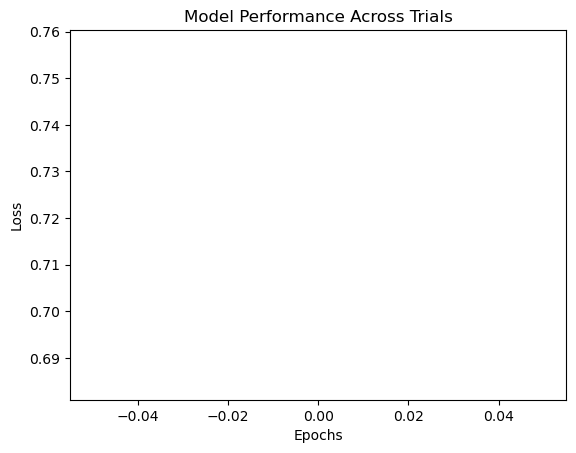

In [88]:
import matplotlib.pyplot as plt

# Get the best trial's metrics
best_trial = tuner.oracle.get_best_trials(1)[0]
metrics_tracker = best_trial.metrics

# Retrieve the 'loss' history
loss_history = metrics_tracker.get_history('loss')

# Check if we have any loss history
print(f"Loss history length: {len(loss_history)}")
if len(loss_history) > 0:
    # Extract the loss values from the MetricObservation objects
    loss_values = [obs.value for obs in loss_history]
    
    # Visualize the loss for each epoch
    plt.plot(loss_values)
    plt.title('Model Performance Across Trials')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
else:
    print("No loss data available.")

In [89]:
best_model.save('ncf_model.keras')  # preferred modern format

In [90]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [91]:
import pickle

with open('user_mapping.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)

with open('movie_mapping.pkl', 'wb') as f:
    pickle.dump(movie_mapping, f)
